# Gravity Density Model

<!--<badge>--><a href="https://colab.research.google.com/github/inlab-geo/cofi-examples/blob/main/notebooks/gravity/gravity_density.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--</badge>-->

> If you are running this notebook locally, make sure you've followed [steps here](https://github.com/inlab-geo/cofi-examples#run-the-examples-with-cofi-locally)
to set up the environment. (This [environment.yml](https://github.com/inlab-geo/cofi-examples/blob/main/environment.yml) file
specifies a list of packages required to run the notebooks)

Adapted from [gravity forward code](https://github.com/inlab-geo/inversion-test-problems/blob/main/contrib/gravityforward/__init__.py) written in inversion-test-problems

---
## 0. Import modules

In [1]:
# -------------------------------------------------------- #
#                                                          #
#     Uncomment below to set up environment on "colab"     #
#                                                          #
# -------------------------------------------------------- #

# !pip install -U cofi

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from cofi import BaseProblem, InversionOptions, Inversion

from gravity_density_lib import *

np.random.seed(42)

---
## 1. Define the problem

<!-- I took out gx, gy for now to make it more straight forward. We can add all kinds of things once it is working.  -->

This problem explores the gravitational acceleration of a three-dimensional density model onto specified receiver locations. In this example, 
only the z-component of the gravityational force 
is calculated. The underlying code itself is capable of calculating all three gravity components 
and six gradiometry components and could be modified quickly if there is the need. 

The gravitational acceleration is calculated using Newton's law of universal gravitation: 

$$
    g (r) =- G \frac{ m} {r^2} 
$$

With G being the gravitational constant, r is the distance of the mass
to the receiver and m is the overall mass of the model, which depends on the density $\rho$ and the volume V:

$$
    m = \int_V {\rho(r) dV}
$$

Here, we solve volume integral for the vertical component of $g$ analytically, using the approach by Plouff et al., 1976:

$$
g_z(M,N)=G \rho \sum_{i=1}^2 \sum_{j=1}^2 \sum_{k=1}^2  (-1)^{i+j+k} [tan^{-1} \frac{a_ib_j}{z_k R_{ijk}} - a_i ln(R_{ijk} + b_j) - b_j ln(R_{ijk} + a_i)]
$$

with $R_{ijk}=\sqrt{a_i^2 + b_j^2 + z_k^2}$ and $a_i, b_j, z_k$ being the distances from receiver N to the 
nodes of the current prism M (i.e. grid cell) in x, y, and z directions. It is assumed that $\rho=const.$ within each grid cell. 
For more information, please see the original paper: 

Plouff, D., 1976. *Gravity and magnetic fields of polygonal prisms and application to magnetic terrain corrections.* **Geophysics**, 41(4), pp.727-741

For further reading, see also Nagy et al., 2000:

Nagy, D., Papp, G. and Benedek, J., 2000. *The gravitational potential and its derivatives for the prism.* **Journal of Geodesy**, 74(7), pp.552-560

**Example details:**

 1. **Model:** Density values on a regularly spaced, rectangular grid. Example-model one is a 3D cube of low density (10 $kgm^{-3}$) containing a centrally located high-density cube (1000 $kgm^{-3}$). Example-model two repeats Figure 2 of Last and Kubik, 1983, which means a pseudo-2D model containing zero-density background cells and centrally high-density cells in the shape of a cross (1000 $kgm^{-3}$).

    Last, B.J. and Kubik, K., 1983. *Compact gravity inversion.* **Geophysics**, 48(6), pp.713-721
    
 2. **Returned data:** Gravitational acceleration (vertical component).
    
 3. **Forward:**  The volume integral is solved analytically following the above described approach by Plouff et al., 1976.


In [3]:
# Load true model and starting guesses
rec_coords, _, _, z_nodes, model = load_gravity_model()
Starting_model1, Starting_model2, Starting_model3 = load_starting_models()

# Create "observed" data by adding noise to forward solution
noise_level=0.05
gz = forward(model)
dataZ_obs= gz + np.random.normal(loc=0,scale=noise_level*np.max(np.abs(gz)),size=np.shape(gz))  

# Create jacobian
Jz = get_jacobian(model)

# Define depth weighting values
z0=18.6
beta=2
# Define regularization parameter
epsilon=0.2

# Create regularization
# Calculate depth weighting fcn - high values at low z, low values at high z, no zeros.
# Model is [Nx1] with N: no. of cells; W is [NxN] with weighting values on diagonal
W=depth_weight(z_nodes[:,0],z0,beta)
W=np.diag(W)

# Set CoFI problem:
grav_problem = BaseProblem()
grav_problem.name = "Gravity"
grav_problem.set_data(gz)

# Here I linked the function, not the result
grav_problem.set_forward(forward)

# Here I linked to the actual jacobian. Jacobian size is (MxN) with M: receiver and N: model cells
grav_problem.set_jacobian(Jz)

# Set regularization; reg is a function that takes the model as input
grav_problem.set_regularisation(reg_l1, epsilon, args=[W])

# Use default L2 misfit
grav_problem.set_data_misfit("L2")
grav_problem.set_initial_model(Starting_model3)

# Set gradient, in hope of helping optimisers converge better
def data_misfit_gradient(model):
    return 2* Jz.T @ (forward(model) - gz) / gz.shape[0]
grav_problem.set_gradient(lambda m: data_misfit_gradient(m) + epsilon*reg_gradient_l1(m, W))

grav_problem.summary()

Summary for inversion problem: Gravity
Model shape: (1728,)
---------------------------------------------------------------------
List of functions/properties set by you:
['gradient', 'jacobian', 'data_misfit', 'regularisation', 'forward', 'data', 'initial_model', 'model_shape']
---------------------------------------------------------------------
List of functions/properties created based on what you have provided:
['objective', 'residual', 'jacobian_times_vector']
---------------------------------------------------------------------
List of functions/properties not set by you:
['objective', 'log_posterior', 'log_posterior_with_blobs', 'log_likelihood', 'log_prior', 'hessian', 'hessian_times_vector', 'residual', 'jacobian_times_vector', 'data_covariance', 'data_covariance_inv', 'walkers_starting_pos', 'blobs_dtype', 'bounds', 'constraints']


---
## 2. Define the inversion

In [4]:
inv_options = InversionOptions()
inv_options.set_tool("scipy.optimize.least_squares")

inv_options.summary()

Summary for inversion options
Solving method: None set
Use `suggest_solving_methods()` to check available solving methods.
-----------------------------
Backend tool: `scipy.optimize.least_squares` - SciPy's non-linear least squares solver with bounds on variables, algorithms include 'trf' (default), 'dogbox', and 'lm'
References: ['https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html']
Use `suggest_tools()` to check available backend tools.
-----------------------------
Solver-specific parameters: None set
Use `suggest_solver_params()` to check required/optional solver-specific parameters.


---
## 3. Start an inversion runner

In [5]:
inv = Inversion(grav_problem, inv_options)
# inv.summary()

In [6]:
inv_result = inv.run()
inv_result.summary()

Summary for inversion result
SUCCESS
----------------------------
cost: 0.003126096786196064
fun: [0.00021396 0.00024856 0.00028794 0.00033178 0.00037902 0.00042766
 0.00047458 0.00051569 0.00054653 0.00056312 0.00056312 0.00054653
 0.00051569 0.00047458 0.00042766 0.00037902 0.00033178 0.00028794
 0.00024856 0.00021396 0.00024856 0.0002936  0.00034639 0.00040702
 0.00047459 0.00054656 0.00061832 0.00068313 0.0007329  0.0007601
 0.0007601  0.0007329  0.00068313 0.00061832 0.00054656 0.00047459
 0.00040702 0.00034639 0.0002936  0.00024856 0.00028794 0.00034639
 0.00041713 0.00050137 0.00059898 0.00070732 0.00081989 0.00092549
 0.00100918 0.00105588 0.00105588 0.00100918 0.00092549 0.00081989
 0.00070732 0.00059898 0.00050137 0.00041713 0.00034639 0.00028794
 0.00033178 0.00040702 0.00050137 0.00061834 0.00076016 0.00092553
 0.00110637 0.00128454 0.00143175 0.00151624 0.00151624 0.00143175
 0.00128454 0.00110637 0.00092553 0.00076016 0.00061834 0.00050137
 0.00040702 0.00033178 0.0003790

Let's see the density image from a vertical plane:

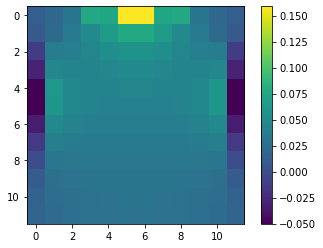

In [7]:
result_model = inv_result.model.reshape(12,12,12)

plt.imshow(result_model[::-1,6,:])
plt.colorbar();

From a different angle:

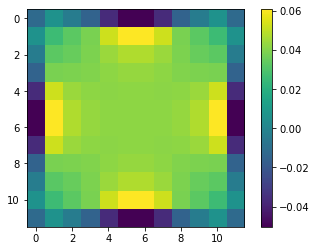

In [8]:
plt.imshow(result_model[6,:,:])
plt.colorbar();

---

## Watermark

In [9]:
watermark_list = ["cofi", "numpy", "scipy", "matplotlib", "emcee", "arviz"]
for pkg in watermark_list:
    pkg_var = __import__(pkg)
    print(pkg, getattr(pkg_var, "__version__"))

cofi 0.1.2.dev6
numpy 1.21.6
scipy 1.8.1
matplotlib 3.5.2
emcee 3.1.2
arviz 0.12.1
